In [1]:
# import necessary libraries
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from textblob import TextBlob
import subprocess
import findspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple
import sys

In [2]:
findspark.init('C:\spark\spark') #initialise spark directory
sc = SparkContext() #make new spark session
ssc = StreamingContext(sc, 10) #we initiate the StreamingContext with 10 second batch interval
sqlContext = SQLContext(sc) #next we initiate our sqlcontext
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) #initiate streaming text from a TCP (socket) source:
lines = socket_stream.window(60) #lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time

In [3]:
#create tuple for hashtag and counting and a named tupel Tweet
hashtagfield = ("hashtag", "count")
Tweet = namedtuple('Tweet', hashtagfield)

#create tupel for sentiment analysis with text and count and a named tupel Sentiment
sentifields = ("text", "count")
Sentiment = namedtuple('Sentiment', sentifields)

In [4]:
sentences = lines.flatMap( lambda text: text.split( "\n" )) #Splits to a list containing of the single tweets 
table = sentences.map( lambda word: (word, 1))  #saves them in a tupel 
sent = table.map( lambda rec: Sentiment(rec[0], rec[1])) #stores the tupel in named tupel Sentiment
sent.foreachRDD( lambda rdd: rdd.toDF().sort(desc("count")).limit(10000).registerTempTable("sentiment")) #save RDDs to a temporary sql table 

text = lines.flatMap(lambda text: text.split(" ")) #Splits to a list
hashtag = text.filter(lambda word: word.lower().startswith("#"))  #Filter hashtag calls  
lowerWord = hashtag.map(lambda word: (word.lower(), 1 )) #Lower cases the word
getCount = lowerWord.reduceByKey(lambda a, b: a + b) #sum up the count of equal hashtags
store = getCount.map(lambda rec: Tweet(rec[0], rec[1])) #stores the tupel in named tupel Tweet
store.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")).limit(5).registerTempTable("tweets")) #Sorts RDDs by hashtag count, registers only top 5 hashtags and saves them to a temporary sql table

In [5]:
#get user input for search
while True:
    search = input("Enter searchword: ")
    if(search != ""):
        print("Search for: " + search)
        break
    print("You have to use a searchword!")

search = search.split(",") #splits user input by ","

f = open("var.py", "w") #opens another file to store search variable 
f.write("search = %s" % search) #overwrite the file
f.close()

file = subprocess.Popen("job.sh", shell = True) #opens job.sh in shell command, which then calls the 

ssc.start() #starts streaming

Enter searchword: covid19, black
Search for: covid19, black


In [6]:
#has to wait 60 seconds to get enough tweets for RDDs because socket_stream.window(60) is set to 60 seconds
print("Wait 60 seconds for data to stream properly...")
time.sleep(60)
print("...successfull")

Wait 60 seconds for data to stream properly...
...successfull


In [7]:
#format text for clear output
def formatText(text):
    formatted_text = ' '.join(word for word in text.split() if (word[0]!='#' and 
                                           word[0]!="@" and 
                                           not word.startswith("http") and 
                                           not word.startswith("RT")))
    return formatted_text

#Get hashtags count from temporary SQL table and plot it
def plot():
    #define error variable
    try:
        ploterror
    except NameError:
        ploterror = 0
    #if try is successful it plot top 5 hashtags and calls sentiment() for sentiment analysis
    try:
        %matplotlib inline
        print("Gather Data for hashtag count...")
        time.sleep(5)
        #top 5 hashtags:
        top_5_tags = sqlContext.sql('Select hashtag, count from tweets') #gets temporary sql table and stores it in file
        top_5_df = top_5_tags.toPandas() #convert file to pandas dataFrame
        print("...successful")
        print("")
        plt.figure( figsize = (10, 8))
        sns.barplot( x="count", y="hashtag", data=top_5_df)
        plt.show()
        plt.clf()
    #if try is not successful set error variable to +1 and try plot() again. If error exceeds 5 then exit()
    except:
        print("Data was not ready....Waiting....")
        time.sleep(30)
        if(ploterror >= 5):
            print("Error on Streaming")
            print("Exiting...")
            ssc.stop()
            sys.exit()
        ploterror += 1
        plot()
    #if no error do sentiment analysis
    sentiment()


#Does sentiment analysis on the twitter text
def sentiment():
    #define error variable
    try:
        sentierror
    except NameError:
        sentierror = 0
    %matplotlib inline
    #if try is successful it does sentiment analysis on the twitter text, prints 5 tweets and plots the polarity count if the overall search topic is neutral/positive/negative
    try:
        print("Gather data for Sentiment Analysis...")
        #sentiment analysis:
        senti = sqlContext.sql('Select text from sentiment') #gets temporary sql table and stores it in file
        sen = senti.toPandas() #convert file to pandas dataFrame
        print("...successful")
        sen['text'].replace('', np.nan, inplace=True) #if text empty replace it with NaN that dropna is recognizing it
        sen.dropna(inplace=True) #drop columns which are empty
        sen.reset_index(drop=True, inplace=True) #reset index for iteration
        dfLen = len(sen) #get number of rows
        positiveList = [] #empty list for storing positive tweets
        negativeList = [] #empty list for storing negative tweets
        neutralList = [] #empty list for storing neutral tweets
        countPosNegNeu = np.array([0, 0, 0]) #array for counting positive and negative tweets --> 0 is negative, 1 is positive, 2 is neutral
        countNames = np.array(["negative", "positive", "neutral"]) #names for plotting
        s = 0 #count variable for plotting 5 tweets with sentiment analysis
        i = 0 #count variable to get every tweet out of sen dataFrame
        print("analyse text for sentiment...")
        try:
            #go through every item in sen["text"], do the sentiment analysis and store in apropriate list
            while i < dfLen:
                opinion = TextBlob(formatText(sen["text"][i])) #compute sentiment analysis on clean text and store it in opinion
                #print 5 tweets with sentiment analysis
                if(s <= 5):
                    print("For the text: ", formatText(sen["text"][i]))
                    print("The text polarity is: %.2f" %opinion.sentiment[0])
                    print("The text subjectivity is: %.2f" %opinion.sentiment[1])
                    print("*****************************************************")
                #store tweets in positive/negative/neutral polarity list
                if(opinion.sentiment[0] > 0):
                    countPosNegNeu[1] += 1 #add 1 to positive count because sentiment was positive
                    positiveList.append(opinion.sentiment[0]) #stores tweet in positive list
                elif(opinion.sentiment[0] < 0):
                    countPosNegNeu[0] += 1 #add 1 to negative count because seintiment was negative
                    negativeList.append(opinion.sentiment[0]) #stores tweet in negative list
                else:
                    countPosNegNeu[2] += 1 #add 1 to neutral count because seintiment was not negative or positive
                    neutralList.append(opinion.sentiment[0]) #stores tweet in neutral list
                i += 1 #count +1 for while loop
                s += 1 #count +1 for text printing
        except:
            print("...not successful!")
        print("...done!")
        print("")
        #print positive/negative/neutral barplot
        try:
            print("Positive/Negative/Neutral Barplot")
            plt.figure(figsize = (10, 8))
            sns.barplot(x=countNames, y=countPosNegNeu)
            plt.show()
            plt.clf() #cleans plot for new plotting
        
            #print positive/negative/neutral boxplot
            print("Positive/Negative Boxplot")
            boxplotdata = pd.DataFrame(list(zip(negativeList, positiveList)), columns =['negative', 'positive']) #do transformation for boxplot printing
            plt.figure(figsize = (10, 8))
            sns.boxplot(data = boxplotdata)
            plt.show()
            plt.clf()
        except:
            pass
    #if try is not successful set error variable to +1 and try sentiment() again. If error exceeds 5 then exit()
    except:
        print("Data was not ready for sentiment...waiting...")
        time.sleep(20)
        if(sentierror >= 5):
            print("Error on sentiment, getting not enough data!")
            print("Exiting...")
            ssc.stop()
            sys.exit()
        sentierror += 1
        sentiment()
    
    #if user wants to do another analysis on same search word execute plot() again. If not exit
    while True:
        exit = input("continue?(y/n) : ")
        if(exit == "y"):
            plot()
        elif(exit == "n"):
            print("Finished! Exiting...")
            break
    ssc.stop()
    sys.exit()

Gather Data for hashtag count...
...successful



Gather data for Sentiment Analysis...
...successful
analyse text for sentiment...
For the text:  also y’all do realize blm doesn’t just apply to wen black people are getting killed right like... it’s the microagressions, hate crimes, lack of representation, etc. as well.... black lives need to matter to y’all when they’re alive as well
The text polarity is: -0.16
The text subjectivity is: 0.45
*****************************************************
For the text:  Tulips basically said I’m not racist I have black friends
The text polarity is: -0.17
The text subjectivity is: 0.43
*****************************************************
For the text:  We’ll know that racism is no longer a problem when y’all elect a Black man as potus with over 20 rape allegations, sex trafficker friends, who has sex with porn stars and prostitutes and has 5 children by three baby mamas.
The text polarity is: 0.32
The text subjectivity is: 0.67
*****************************************************
For the text:

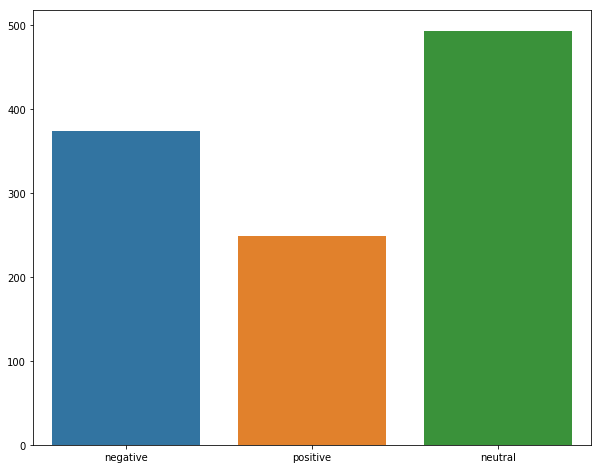

Positive/Negative Boxplot


<Figure size 432x288 with 0 Axes>

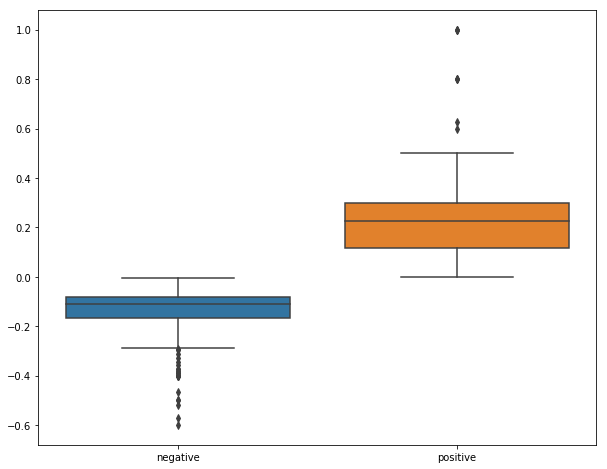

In [ ]:
plot()